# Open2C framework

# `pairtools`: Convert sequencing data to a list of contacts

## Check out the bamfiles

In [1]:
%%bash 

cd ../steps/bowtie2/local/bamfiles

samtools view SRR6502335_1.bam | head -n1

SRR6502335.1	16	chr2	194419849	44	149M1S	*	0	0	AGAGAGAAAGAGTAGAAGGGAGAAACAAAGGGCAGGAGAGGGGATAGATGAAGAGGAACTAGACTTTGCACATATTGGCTGGCAATGATGGAATAGTCCAGTTTCAAAGAGTGAGATCTTGTAGTTATCTTCTCATTTATTCACTTAATN	<FFAF-J7AJJA7AFA77-<AAF-7-A7-7A7-FJ<FA7FAA-7--AAA--<<A7FFJAJJJA<-A-F7F7<-A<F7---<A<JJFFAAF7JFAAJ<FFJF-<-FJJFFFFFJFAF<<-AJJJJJFFF-JFJFFJF7AFJFFFAA-AAA#	AS:i:285	XN:i:0	XM:i:2	XO:i:0	XG:i:0	NM:i:2	MD:Z:44G78A25	YT:Z:UU


In [2]:
%%bash 

cd ../steps/bowtie2/local/bamfiles/paired

samtools view SRR6502335_paired.bam | head -n1

SRR6502335.1	0	chr2	194419717	44	10S140M	*	0	0	NTTCTGGATCGATCATTTTTACATTATTTTTGCCTATGAACCAACTTTCAAAATTATTTCTCGTTTAAAATACAATTCAATGAGGTATTCATTTTTGTCTGGGGGGAAAGATGGAAGGTAGGAAGAAGAAAGAAGTGAAGAAAGAGAGAA	#AAAFAF<JJJJJJFJJJJJJJ-JJFJJJJJ<JAA-FF-FFAAFJFJFJJ--7<F-AJFFAJFFFJF-7FF-FJF<FFJFJFFF<JA<AJA7<AJ<AJFJ<---77-7--7-7<AAFFAF77<FJ-<<--7-AFJ---7AF<AAF--7<7	AS:i:275	XN:i:0	XM:i:1	XO:i:0	XG:i:0	NM:i:1	MD:Z:125G14	YT:Z:UU


### I had to decompress the reference genome

To make `samtools faidx` work (or compress with `bgzip`, not `gunzip`)

In [14]:
%%bash 

cd /home/sojern/hic-spermatogenesis/data/macaque_raw/ucsc_ref

gunzip -k rheMac10.fa.gz

## Pair and sort the bamfiles (workfflow) - turned out not to work (no mapped reads were left after filtering)

In [6]:
from IPython.display import display, Markdown

# Read the content of the Python file
with open('../gwf_pair_alignments.py', 'r') as file:
    file_content = file.read()

# Display the content as Markdown
display(Markdown(f"```python\n{file_content}\n```"))

```python
# %% [markdown]
# ---
# title: "gwf_bowtie_local"
# author: Søren Jørgensen
# date: last-modified
# execute: 
#   enabled: false
# ---

# %%
from gwf import *
import glob
import os.path as op

#######################################
#
# GWF workflow to pair alignments from mate-pair sequencing, after mapping to the reference individually.
# After mapping, the mate-pairs are merged with `samtools merge` (another workflow) and then parsed with `pairtools parse`. 
#
# How to run:
# conda activate gwf
# gwf -f gwf_gwf_pair_alignments.py status
#
# Workflow:
#   1   pairtools parse : Parse the fastq files into pairs (after merging with `samtools merge`)
#
# Footnote: always activate the conda environment before running the workflow:
# source $(conda info --base)/etc/profile.d/conda.sh
# conda activate env_name
#######################################

# Create a workflow object
gwf = Workflow(defaults={'nodes': 1, 'queue':"normal", 'account':"hic-spermatogenesis"})

#############################################
############### Templates ###################
#############################################

def pair_sort_alignments(chromsizes, bam_merged, sorted_pairs):
    """Pair the merged alignments from mate-pair sequencing with `pairtools parse`"""
    inputs = [bam_merged]
    outputs = [f"{bam_merged}_parsed.stats", 
               sorted_pairs]
    options = {'cores':12, 'memory':"4g", 'walltime':"01:00:00"}
    spec=f"""
source $(conda info --base)/etc/profile.d/conda.sh
conda activate hic
pairtools parse \
    -c {chromsizes} \
    --drop-sam --drop-seq \
    --output-stats {bam_merged}_parsed.stats \
    --add-columns mapq \
    --assembly rheMac10 --no-flip \
    --walks-policy mask \
    {bam_merged} | \
pairtools sort -o {sorted_pairs} 
"""
    return AnonymousTarget(inputs=inputs, outputs=outputs, options=options, spec=spec)

def dedup(sorted_pairs, ):
    """Deduplicate the sorted pairs with `pairtools dedup`"""

    pairs_prefix = sorted_pairs.split(".sorted")[0]
    inputs = [sorted_pairs]
    outputs = [f"{pairs_prefix}.nodups.pairs.gz",
               f"{pairs_prefix}.nodups.bam",
               f"{pairs_prefix}.unmapped.pairs.gz",
               f"{pairs_prefix}.unmapped.bam",
               f"{pairs_prefix}.dups.pairs.gz",
               f"{pairs_prefix}.dups.bam",
               f"{pairs_prefix}.dedup.stats"]
    options = {'cores':12, 'memory': "4g", 'walltime': "01:00:00"}
    spec = f"""
source $(conda info --base)/etc/profile.d/conda.sh
conda activate hic
pairtools dedup \
    --max-mismatch 3 \
    --mark-dups \
    --output \
        >(pairtools split \
            --output-pairs {pairs_prefix}.nodups.pairs.gz \
            --output-sam {pairs_prefix}.nodups.bam \
         ) \
    --output-unmapped \
        >( pairtools split \
            --output-pairs {pairs_prefix}.unmapped.pairs.gz \
            --output-sam {pairs_prefix}.unmapped.bam \
         ) \
    --output-dups \
        >( pairtools split \
            --output-pairs {pairs_prefix}.dups.pairs.gz \
            --output-sam {pairs_prefix}.dups.bam \
            ) \
    --output-stats {pairs_prefix}.dedup.stats \
    {sorted_pairs}

    """
    return AnonymousTarget(inputs=inputs, outputs=outputs, options=options, spec=spec)


#############################################
################ Targets ####################
#############################################

# Define the chromsizes file
chromsizes = "data/links/ucsc_ref/misc/rheMac10.chrom.sizes"

# Find the merged bam files
merged_bams = gwf.glob("steps/bowtie2/local/bamfiles/paired/*_paired.bam")

sorted_bams = sorted(merged_bams)


for inbam in sorted_bams:
    base = op.basename(inbam)
    prefix = base.split("_paired")[0]
    
    outdir = "steps/bowtie2/local/bamfiles/paired/"
    outfile = f"{base.split("_paired")[0]}" + ".sorted.pairs.gz"
    out_sorted_pairs = op.join(outdir, outfile)

    gwf.target_from_template(f"pair_sort_{prefix}",
                            pair_sort_alignments(chromsizes, inbam, out_sorted_pairs))
    
    gwf.target_from_template(f"dedup_{prefix}",
                            dedup(out_sorted_pairs))
```

## Map the reads again but as PE reads in stead (`cooler` recommendation, workflow)

In [12]:
from IPython.display import display, Markdown

# Read the content of the Python file
with open('../gwf_bwamem.py', 'r') as file:
    file_content = file.read()

# Display the content as Markdown
display(Markdown(f"```python\n{file_content}\n```"))

```python
# %% [markdown]
# ---
# title: "gwf_map_reads"
# author: Søren Jørgensen
# date: last-modified
# execute: 
#   enabled: false
# ---

# %%
from gwf import *
import glob
import os

#######################################
#
# GWF workflow to map Hi-C reads to pairs with `bwa` and `samtools`.
# Pairs are generated with `pairtools parse` and deduplicated with `pairtools dedup`.
#
# How to run:
# conda activate gwf
# gwf -f gwf_bwamem.py status
#
# Workflow:
#   1a bwa_index        : [Reference genome] Index the reference genome with `bwa index`
#   1b sam_index        : [Reference genome] Index the fasta again with `samtools faidx``
#   2  bwa_map          : Map reads (PE) to the reference with `bwa mem` 
#   3  pair_sort        : Pair the merged alignments from mate-pair sequencing with `pairtools parse`, 
#                         then sort with `pairtools sort`
#   4  dedup            : Deduplicate the sorted pairs with `pairtools dedup`  
#
#######################################

# Create a workflow object
gwf = Workflow(defaults={'nodes': 1, 'queue':"normal", 'account':"hic-spermatogenesis"})

#############################################
############### Templates ###################
#############################################

def bwa_index(ref_genome):
    """Template for indexing the reference genome with bwa"""
    inputs  = [ref_genome]
    outputs = [f"{ref_genome}.amb", 
               f"{ref_genome}.ann", 
               f"{ref_genome}.bwt", 
               f"{ref_genome}.pac", 
               f"{ref_genome}.sa"]
    options = {'cores':1, 'memory': "5g", 'walltime':"02:00:00"}
    spec = f'''
source $(conda info --base)/etc/profile.d/conda.sh
conda activate hic
bwa index -p {ref_genome} -a bwtsw {ref_genome}
'''
    return AnonymousTarget(inputs=inputs, outputs=outputs, options=options, spec=spec)

def sam_index(ref_genome):
    """Creating a Fasta index. `bwa mem` also needs a fasta index generated by samtools"""
    inputs = [ref_genome]
    outputs = [f"{ref_genome}.fai"]
    options = {'cores':1, 'memory':"5g", 'walltime':"00:20:00"}
    spec=f"""
source $(conda info --base)/etc/profile.d/conda.sh
conda activate hic
samtools faidx {ref_genome}
"""
    return AnonymousTarget(inputs=inputs, outputs=outputs, options=options, spec=spec)


def bwa_map(ref_genome, mate_1, mate_2, out_bam):
    """
    Template for mapping reads to a reference genome using `bwa` and `samtools`. 
    NB! Here, we map the mates together, as bwa states it is no problem for Hi-C reads. 
    """
    threads = 32
    inputs = [f"{ref_genome}.amb", 
              f"{ref_genome}.ann", 
              f"{ref_genome}.bwt", 
              f"{ref_genome}.pac", 
              f"{ref_genome}.sa", 
              f"{ref_genome}.fai",
              mate_1, mate_2]
    outputs = [out_bam]
    options = {'cores':threads, 'memory': "32g", 'walltime':"06:00:00"}
    spec = f"""
source $(conda info --base)/etc/profile.d/conda.sh
conda activate hic
bwa mem -t {threads} -SP {ref_genome} {mate_1} {mate_2} > {out_bam}
"""
    return AnonymousTarget(inputs=inputs, outputs=outputs, options=options, spec=spec)

def pair_sort_alignments(chromsizes, bam_merged, sorted_pairs):
    """Pair the merged alignments from mate-pair sequencing with `pairtools parse`"""
    inputs = [bam_merged]
    outputs = [f"{bam_merged}_parsed.stats", 
               sorted_pairs]
    options = {'cores':12, 'memory':"4g", 'walltime':"02:00:00"}
    spec=f"""
source $(conda info --base)/etc/profile.d/conda.sh
conda activate hic
pairtools parse \
    -c {chromsizes} \
    --drop-sam --drop-seq \
    --output-stats {bam_merged}_parsed.stats \
    --add-columns mapq \
    --assembly rheMac10 --no-flip \
    --walks-policy mask \
    {bam_merged} | \
pairtools sort -o {sorted_pairs} 
"""
    return AnonymousTarget(inputs=inputs, outputs=outputs, options=options, spec=spec)

def dedup(sorted_pairs):
    """Deduplicate the sorted pairs with `pairtools dedup`"""
    pairs_prefix = sorted_pairs.split(".sorted")[0]
    inputs = [sorted_pairs]
    outputs = [f"{pairs_prefix}.nodups.pairs.gz",
               f"{pairs_prefix}.nodups.bam",
               f"{pairs_prefix}.unmapped.pairs.gz",
               f"{pairs_prefix}.unmapped.bam",
               f"{pairs_prefix}.dups.pairs.gz",
               f"{pairs_prefix}.dups.bam",
               f"{pairs_prefix}.dedup.stats"]
    options = {'cores':12, 'memory': "4g", 'walltime': "01:00:00"}
    spec = f"""
source $(conda info --base)/etc/profile.d/conda.sh
conda activate hic
pairtools dedup \
    --max-mismatch 3 \
    --mark-dups \
    --output \
        >(pairtools split \
            --output-pairs {pairs_prefix}.nodups.pairs.gz \
            --output-sam {pairs_prefix}.nodups.bam \
         ) \
    --output-unmapped \
        >( pairtools split \
            --output-pairs {pairs_prefix}.unmapped.pairs.gz \
            --output-sam {pairs_prefix}.unmapped.bam \
         ) \
    --output-dups \
        >( pairtools split \
            --output-pairs {pairs_prefix}.dups.pairs.gz \
            --output-sam {pairs_prefix}.dups.bam \
            ) \
    --output-stats {pairs_prefix}.dedup.stats \
    {sorted_pairs}

    """
    return AnonymousTarget(inputs=inputs, outputs=outputs, options=options, spec=spec)



#############################################
############### Create targets ##############
#############################################

# Do stuff with the [unpacked] reference genome
ref_genome = "data/links/ucsc_ref/rheMac10.fa"

T1a = gwf.target_from_template(f"bwa_index_{os.path.basename(ref_genome)}", 
                               bwa_index(ref_genome=ref_genome))
T1b = gwf.target_from_template(f"sam_index_{os.path.basename(ref_genome)}", 
                               sam_index(ref_genome=ref_genome))


# Define the chromsizes file
chromsizes = "data/links/ucsc_ref/misc/rheMac10.chrom.sizes"


# Locate Hi-C reads 
fastq_folder = "data/links/macaque_fastq/"
fastq_files = glob.glob(os.path.join(fastq_folder, "*.fastq.gz"))

# Pair the files (make sure they have the same base name prefix):
fastq_files.sort()
paired_fastq_files = list(zip(fastq_files[::2], fastq_files[1::2]))

for f1,f2 in paired_fastq_files:
    
    # Get the base names
    basename_1 = os.path.basename(f1).split('.fast')[0]
    basename_2 = os.path.basename(f2).split('.fast')[0]
    
    # Combine pair names
    pairname = os.path.commonprefix([basename_1, basename_2]).split('_')[0]

    # Create the output bam filenames
    bam_dir = f"steps/bwa/PE/bamfiles/"
    bam_file = pairname + ".PE.bam"
    out_bam = os.path.join(bam_dir, bam_file)

    # Create targets for mapping
    T2 = gwf.target_from_template(f"bwa_map_{pairname}", 
                                  bwa_map(ref_genome=ref_genome, 
                                          mate_1=f1, mate_2=f2, 
                                          out_bam=out_bam))
    
    # Create targets for sorting the pairs
    pair_dir = "steps/bwa/PE/pairs/"
    pair_file = pairname + ".sorted.pairs.gz"
    sorted_pairs = os.path.join(pair_dir, pair_file)

    T3 = gwf.target_from_template(f"pair_sort_{pairname}", 
                                  pair_sort_alignments(chromsizes=chromsizes, 
                                                       bam_merged=out_bam, 
                                                       sorted_pairs=sorted_pairs))
    
    T4 = gwf.target_from_template(f"dedup_{pairname}", dedup(sorted_pairs=sorted_pairs))
    




    


```

## Check the sorted pairs

In [14]:
%%bash

#cd ../steps/bowtie2/local/bamfiles/paired
cd ../steps/bwa/PE/pairs

# Unique pairs:
gzip -dc SRR6502339.nodups.pairs.gz | grep -v '#' |  head -n 5

echo "--"

# Only dups
gzip -dc SRR6502339.dups.pairs.gz | grep -v '#' |  head -n 5

echo "--"


SRR6502339.38272510	chr1	898	chr1	1026	+	-	UU	3	3
SRR6502339.13727657	chr1	976	chr1	175669579	+	-	UR	4	60
SRR6502339.67930411	chr1	1035	chr1	99209	+	-	UU	22	60
SRR6502339.90172213	chr1	1134	chr1	11385306	-	+	UR	9	60
SRR6502339.53849219	chr1	5186	chr1	56858619	+	-	UR	2	60
--
SRR6502339.53849978	chr1	5186	chr1	56858619	+	-	DD	2	60
SRR6502339.67632192	chr1	13335	chr1	370581	+	-	DD	3	7
SRR6502339.92006828	chr1	16215	chr1	16560	+	-	DD	35	12
SRR6502339.71065550	chr1	19644	chr1	62483	+	-	DD	23	60
SRR6502339.89600080	chr1	19644	chr1	62483	+	-	DD	25	60
--


[main_samview] fail to read the header from "SRR6502339.nodups.bam".


## Visualize Stats: `pairtools stats`

It might be the same stats that are (optionally) returned from `pairtools parse`. 

Let's look at the parsed stats in a nice way: 

### If it is not the same, then run this command on all the sorted pairs. 

In [20]:
%%bash 

cd ../steps/bwa/PE/pairs

#pairtools stats SRR6502339.sorted.pairs.gz -o test.stats

### Otherwise, just use `MultiQC`

#### Generate the MultiQC files

#### Now visualize:

##### All results merged (before dedup)

In [104]:
from IPython.display import IFrame

IFrame(src='../steps/bwa/PE/bamfiles/Fibroblasts_all_multiqc_report.html', width=1400, height=900)

In [101]:
%%bash 

cd ../steps/bwa/PE/pairs/

multiqc -i Fibroblasts_all.dedup --no-data-dir  *.stats 


/// ]8;id=807531;https://multiqc.info\MultiQC]8;;\ 🔍 v1.25.1

     update_config | Report title: Fibroblasts_all.dedup
       file_search | Search path: /faststorage/project/hic-spermatogenesis/people/sojern/hic-spermatogenesis/steps/bwa/PE/pairs/SRR6502335.dedup.stats
       file_search | Search path: /faststorage/project/hic-spermatogenesis/people/sojern/hic-spermatogenesis/steps/bwa/PE/pairs/SRR6502336.dedup.stats
       file_search | Search path: /faststorage/project/hic-spermatogenesis/people/sojern/hic-spermatogenesis/steps/bwa/PE/pairs/SRR6502337.dedup.stats
       file_search | Search path: /faststorage/project/hic-spermatogenesis/people/sojern/hic-spermatogenesis/steps/bwa/PE/pairs/SRR6502338.dedup.stats
       file_search | Search path: /faststorage/project/hic-spermatogenesis/people/sojern/hic-spermatogenesis/steps/bwa/PE/pairs/SRR6502339.dedup.stats
         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 5/5  .dedup.statsmSRR6502338.dedup.stats
         pair

In [103]:
from IPython.display import IFrame

IFrame(src='../steps/bwa/PE/pairs/Fibroblasts_all.dedup_multiqc_report.html', width=1400, height=900)

## Dedup the pairs and visualize stats again

The pairs was deduplicated with a gwf workflow `gwf_bwamem.py`

In [1]:
%%bash 

cd ../steps/bwa/PE/pairs/sorted

multiqc -i fibroblast.dedup --no-data-dir *.stats


/// ]8;id=271458;https://multiqc.info\MultiQC]8;;\ 🔍 v1.25.1

     update_config | Report title: fibroblast.dedup
       file_search | Search path: /faststorage/project/hic-spermatogenesis/people/sojern/hic-spermatogenesis/steps/bwa/PE/pairs/sorted/SRR6502335.dedup.stats
       file_search | Search path: /faststorage/project/hic-spermatogenesis/people/sojern/hic-spermatogenesis/steps/bwa/PE/pairs/sorted/SRR6502336.dedup.stats
       file_search | Search path: /faststorage/project/hic-spermatogenesis/people/sojern/hic-spermatogenesis/steps/bwa/PE/pairs/sorted/SRR6502337.dedup.stats
       file_search | Search path: /faststorage/project/hic-spermatogenesis/people/sojern/hic-spermatogenesis/steps/bwa/PE/pairs/sorted/SRR6502338.dedup.stats
       file_search | Search path: /faststorage/project/hic-spermatogenesis/people/sojern/hic-spermatogenesis/steps/bwa/PE/pairs/sorted/SRR6502339.dedup.stats
         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 5/5  0/5  
         pair

In [3]:
from IPython.display import IFrame

IFrame(src='../steps/bwa/PE/pairs/sorted/fibroblast.dedup_multiqc_report.html', width=1400, height=900)

# `cooler`: Make the pairs `cool`

In [97]:
%%bash 

# Filter the chromsizes to only include the placed scaffolds

echo "Lines in unfiltered chrom.sizes:" $(cat ../data/links/ucsc_ref/misc/rheMac10.chrom.sizes | grep -c "")

cat ../data/links/ucsc_ref/misc/rheMac10.chrom.sizes | grep -Pv "^chrUn|^chrM|_random" | sort -V > ../data/links/ucsc_ref/misc/rheMac10.filtered.chrom.sizes

echo "New filtered.chrom.sizes:"
cat ../data/links/ucsc_ref/misc/rheMac10.filtered.chrom.sizes


Lines in unfiltered chrom.sizes: 2939
New filtered.chrom.sizes:
chr1	223616942
chr2	196197964
chr3	185288947
chr4	169963040
chr5	187317192
chr6	179085566
chr7	169868564
chr8	145679320
chr9	134124166
chr10	99517758
chr11	133066086
chr12	130043856
chr13	108737130
chr14	128056306
chr15	113283604
chr16	79627064
chr17	95433459
chr18	74474043
chr19	58315233
chr20	77137495
chrX	153388924
chrY	11753682


In [20]:
%%bash

cd ../steps/bwa/PE/pairs/sorted/

echo $PWD 

du -ha SRR650233*.gz

/faststorage/project/hic-spermatogenesis/people/sojern/hic-spermatogenesis/steps/bwa/PE/pairs/sorted \n
287M	SRR6502335.dups.pairs.gz
1.8G	SRR6502335.nodups.pairs.gz
2.7G	SRR6502335.sorted.pairs.gz
722M	SRR6502335.unmapped.pairs.gz
323M	SRR6502336.dups.pairs.gz
1.6G	SRR6502336.nodups.pairs.gz
2.3G	SRR6502336.sorted.pairs.gz
621M	SRR6502336.unmapped.pairs.gz
190M	SRR6502337.dups.pairs.gz
1.3G	SRR6502337.nodups.pairs.gz
1.9G	SRR6502337.sorted.pairs.gz
528M	SRR6502337.unmapped.pairs.gz
131M	SRR6502338.dups.pairs.gz
1.4G	SRR6502338.nodups.pairs.gz
2.0G	SRR6502338.sorted.pairs.gz
512M	SRR6502338.unmapped.pairs.gz
150M	SRR6502339.dups.pairs.gz
667M	SRR6502339.nodups.pairs.gz
1.1G	SRR6502339.sorted.pairs.gz
274M	SRR6502339.unmapped.pairs.gz


In [ ]:
%%bash

ref=../data/links/ucsc_ref/misc/rheMac10.chrom.sizes

for INFILE in ../steps/bwa/PE/pairs/sorted/*.nodups*; do
    base=$(basename $INFILE .pairs.gz)
    outfile=../steps/bwa/PE/pairs/cool/$base.10000.cool
    
    echo $base '-->' $outfile

    cooler cload pairs \
    -c1 2 -p1 3 -c2 4 -p2 5 \
    --assembly rheMac10 \
    --chunksize 50000 \
    $ref:10000 \
    $INFILE \
    $outfile &
    
done 

wait

# `cooler`: access and plot Hi-C data

## Introduction 

First, we have to check the data output from HiCExplorer. The output is a `.cool` file, which is a binary format for storing Hi-C data. The file contains the binned contact matrix and the genomic coordinates of the bins.

The `cooler` package is a Python library for working with `.cool` files. It provides tools for reading, writing, and manipulating Hi-C data. The `cooltools` package is a collection of tools for analyzing Hi-C data, including normalization, visualization, and interaction calling.

## Follow `cooler` walkthrough from the documentation

In [2]:
# Import the packages we will use
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py

import cooler

In [3]:
# The following directive activates inline plotting
%matplotlib inline

In [4]:
# Define the filepath (I choose the uncorrected matrix)

filepath = "../steps/bowtie2/local/matrices/filtered_pooled_10kb.cool"


### Direct access with `h5py`

In [5]:
h5 = h5py.File(filepath, 'r')
h5

<HDF5 file "filtered_pooled_10kb.cool" (mode r)>

In [6]:
h5.keys()

<KeysViewHDF5 ['bins', 'chroms', 'indexes', 'pixels']>

In [7]:
h5['pixels']

<HDF5 group "/pixels" (3 members)>

In [8]:
list(h5['pixels'].keys())

['bin1_id', 'bin2_id', 'count']

h5py dataset objects are views onto the data on disk

In [9]:
h5['pixels']['bin2_id']

<HDF5 dataset "bin2_id": shape (117090191,), type "<i4">

Slicing or indexing returns a numpy array in memory.

In [10]:
h5['pixels']['bin2_id'][:10]

array([   0,    9,   30,   33,  124,  127,  145,  756, 1167, 2416],
      dtype=int32)

In [11]:
h5['pixels']['count'][:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
h5.close()

The Python cooler package is just a thin wrapper over h5py.

* It lets you access the data tables as Pandas data frames and series.
* It also provides a matrix abstraction: letting you query the upper triangle pixel table as if it were a full rectangular sparse matrix via SciPy.

### The `Cooler` class

Accepts a file path or an open HDF5 file object.

NOTE: Using a filepath allows the `Cooler` object to be  serialized/pickled since the file is only opened when needed

In [13]:
c = cooler.Cooler(filepath)

In [14]:
c.info

{'bin-size': 10000,
 'bin-type': 'fixed',
 'creation-date': '2024-09-24T21:20:38.656143',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/mirnylab/cooler',
 'format-version': 3,
 'generated-by': 'HiCMatrix-17.2',
 'generated-by-cooler-lib': 'cooler-0.10.2',
 'genome-assembly': 'unknown',
 'metadata': {'format': 'HDF5::Cooler',
  'format-url': 'https://github.com/mirnylab/cooler',
  'generated-by': 'HiCMatrix-17.2',
  'generated-by-cooler-lib': 'cooler-0.10.2',
  'tool-url': 'https://github.com/deeptools/HiCMatrix'},
 'nbins': 285406,
 'nchroms': 22,
 'nnz': 117090191,
 'storage-mode': 'symmetric-upper',
 'sum': 193589731.0,
 'tool-url': 'https://github.com/deeptools/HiCMatrix'}

In [15]:
c.chroms()

The return value is a selector or "view" on a table that accepts column and range queries ("slices").

* Column selections return a new view.
* Range selections return pandas DataFrames or Series.

In [16]:
# Get a slice of the chromosomes
c.chroms()[0:5]

# Or the whole dict
#c.chroms()[:]

,name,length
0,chr1,223616942
1,chr2,196197964
2,chr3,185288947
3,chr4,169963040
4,chr5,187317192


In [17]:
# Convenience
c.chromnames, c.chromsizes

(['chr1',
  'chr2',
  'chr3',
  'chr4',
  'chr5',
  'chr6',
  'chr7',
  'chr8',
  'chr9',
  'chr10',
  'chr11',
  'chr12',
  'chr13',
  'chr14',
  'chr15',
  'chr16',
  'chr17',
  'chr18',
  'chr19',
  'chr20',
  'chrX',
  'chrY'],
 name
 chr1     223616942
 chr2     196197964
 chr3     185288947
 chr4     169963040
 chr5     187317192
 chr6     179085566
 chr7     169868564
 chr8     145679320
 chr9     134124166
 chr10     99517758
 chr11    133066086
 chr12    130043856
 chr13    108737130
 chr14    128056306
 chr15    113283604
 chr16     79627064
 chr17     95433459
 chr18     74474043
 chr19     58315233
 chr20     77137495
 chrX     153388924
 chrY      11753682
 Name: length, dtype: int32)

In [18]:
# Access bins
c.bins()[:10]

,chrom,start,end
0,chr1,0,10000
1,chr1,10000,20000
2,chr1,20000,30000
3,chr1,30000,40000
4,chr1,40000,50000
5,chr1,50000,60000
6,chr1,60000,70000
7,chr1,70000,80000
8,chr1,80000,90000
9,chr1,90000,100000


Selecting a list of columns returns a new DataFrame view on that subset of columns

In [19]:
bins = c.bins()[['chrom', 'start', 'end']]
bins

In [20]:
bins[:5]

,chrom,start,end
0,chr1,0,10000
1,chr1,10000,20000
2,chr1,20000,30000
3,chr1,30000,40000
4,chr1,40000,50000


The pixel table contains the non-zero upper triangle entries of the contact map.

In [21]:
# Use the join=True option if you would like to expand the bin IDs into genomic bin coordinates by joining the output with the bin table.

display(c.pixels()[:10], c.pixels(join=True)[:10])

,bin1_id,bin2_id,count
0,0,0,1.0
1,0,9,1.0
2,0,30,1.0
3,0,33,1.0
4,0,124,1.0
5,0,127,1.0
6,0,145,1.0
7,0,756,1.0
8,0,1167,1.0
9,0,2416,1.0


,chrom1,start1,end1,chrom2,start2,end2,count
0,chr1,0,10000,chr1,0,10000,1.0
1,chr1,0,10000,chr1,90000,100000,1.0
2,chr1,0,10000,chr1,300000,310000,1.0
3,chr1,0,10000,chr1,330000,340000,1.0
4,chr1,0,10000,chr1,1240000,1250000,1.0
5,chr1,0,10000,chr1,1270000,1280000,1.0
6,chr1,0,10000,chr1,1450000,1460000,1.0
7,chr1,0,10000,chr1,7560000,7570000,1.0
8,chr1,0,10000,chr1,11670000,11680000,1.0
9,chr1,0,10000,chr1,24160000,24170000,1.0


Dump any table selection with pandas to tabular

In [22]:
df = c.pixels(join=True)[:100]

# df.to_csv('data/myselection.txt'), sep='\t', index=False, header=False) 

### Bin annotation

Another way to annotate the bins in a data frame of pixels is to use cooler.annotate. It does a left outer join from the bin1_id and bin2_id columns onto a data frame indexed by bin ID that describes the bins.

In [23]:
bins = c.bins()[:] # fetch all
pix = c.pixels()[100:110] # select some pixels
pix

,bin1_id,bin2_id,count
100,2,481,1.0
101,2,500,1.0
102,2,519,1.0
103,2,557,1.0
104,2,580,1.0
105,2,594,1.0
106,2,606,1.0
107,2,621,1.0
108,2,625,1.0
109,2,646,1.0


In [24]:
cooler.annotate(pix, bins)

,chrom1,start1,end1,chrom2,start2,end2,bin1_id,bin2_id,count
100,chr1,20000,30000,chr1,4810000,4820000,2,481,1.0
101,chr1,20000,30000,chr1,5000000,5010000,2,500,1.0
102,chr1,20000,30000,chr1,5190000,5200000,2,519,1.0
103,chr1,20000,30000,chr1,5570000,5580000,2,557,1.0
104,chr1,20000,30000,chr1,5800000,5810000,2,580,1.0
105,chr1,20000,30000,chr1,5940000,5950000,2,594,1.0
106,chr1,20000,30000,chr1,6060000,6070000,2,606,1.0
107,chr1,20000,30000,chr1,6210000,6220000,2,621,1.0
108,chr1,20000,30000,chr1,6250000,6260000,2,625,1.0
109,chr1,20000,30000,chr1,6460000,6470000,2,646,1.0


In [25]:
cooler.annotate(pix, bins[['start']], replace=False)

,start1,start2,bin1_id,bin2_id,count
100,20000,4810000,2,481,1.0
101,20000,5000000,2,500,1.0
102,20000,5190000,2,519,1.0
103,20000,5570000,2,557,1.0
104,20000,5800000,2,580,1.0
105,20000,5940000,2,594,1.0
106,20000,6060000,2,606,1.0
107,20000,6210000,2,621,1.0
108,20000,6250000,2,625,1.0
109,20000,6460000,2,646,1.0


### Enter the Matrix

Finally, the `matrix` method provides a 2D-sliceable view on the data. It allows you to query the data on file as a full rectangular contact matrix.

In [26]:
c.matrix()

In [27]:
arr = c.matrix(balance=False)[1000:1200, 1000:1200]
arr

array([[ 57.,  33.,   9., ...,   0.,   1.,   0.],
       [ 33.,  88.,  33., ...,   1.,   0.,   0.],
       [  9.,  33.,  74., ...,   0.,   0.,   0.],
       ...,
       [  0.,   1.,   0., ..., 104.,  27.,  12.],
       [  1.,   0.,   0., ...,  27., 118.,  46.],
       [  0.,   0.,   0., ...,  12.,  46., 135.]])

In [28]:
# Use sparse=True to return a scipy.sparse.coo_matrix in stead

mat = c.matrix(balance=False, sparse=True)[1000:1200,1000:1200]
mat

<200x200 sparse matrix of type '<class 'numpy.float64'>'
	with 26544 stored elements in COOrdinate format>

Convert to a 2D numpy array

In [29]:
arr = mat.toarray()
arr

array([[ 57.,  33.,   9., ...,   0.,   1.,   0.],
       [ 33.,  88.,  33., ...,   1.,   0.,   0.],
       [  9.,  33.,  74., ...,   0.,   0.,   0.],
       ...,
       [  0.,   1.,   0., ..., 104.,  27.,  12.],
       [  1.,   0.,   0., ...,  27., 118.,  46.],
       [  0.,   0.,   0., ...,  12.,  46., 135.]])

Notice that tha lower triangle has automatically been filled

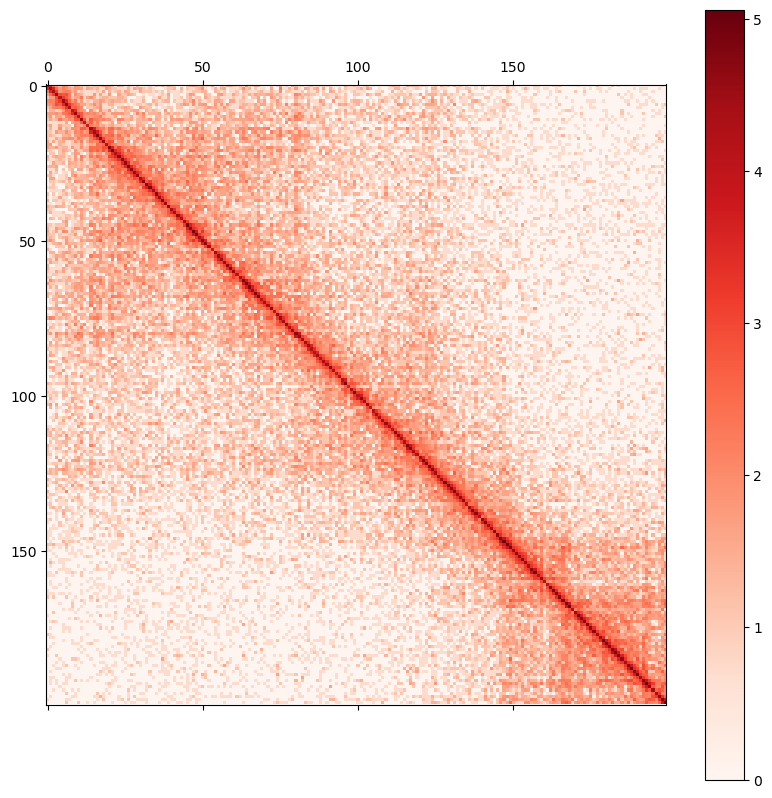

In [30]:
# Plot
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111)
im  = ax.matshow(np.log1p(arr), cmap='Reds')
fig.colorbar(im) 

## Use the new pairs

In [1]:
# Import the packages we will use
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py

import cooler

# The following directive activates inline plotting
%matplotlib inline

In [2]:
filepath = "../steps/bwa/PE/pairs/cool/SRR6502335.nodups.10000.cool"

In [3]:
c = cooler.Cooler(filepath)
c.info

{'bin-size': 10000,
 'bin-type': 'fixed',
 'creation-date': '2024-10-08T14:31:29.159937',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/open2c/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.10.2',
 'genome-assembly': 'rheMac10',
 'metadata': {},
 'nbins': 298615,
 'nchroms': 2939,
 'nnz': 67535020,
 'storage-mode': 'symmetric-upper',
 'sum': 115865253}

In [4]:
c.bins()[:100]

,chrom,start,end
0,chr1,0,10000
1,chr1,10000,20000
2,chr1,20000,30000
3,chr1,30000,40000
4,chr1,40000,50000
...,...,...,...
95,chr1,950000,960000
96,chr1,960000,970000
97,chr1,970000,980000
98,chr1,980000,990000


In [5]:
c.matrix()

In [6]:
arr = c.matrix(balance=False).fetch('chrX')
arr

array([[39,  0,  4, ...,  0,  0,  0],
       [ 0,  9,  3, ...,  0,  0,  0],
       [ 4,  3, 29, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  7,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

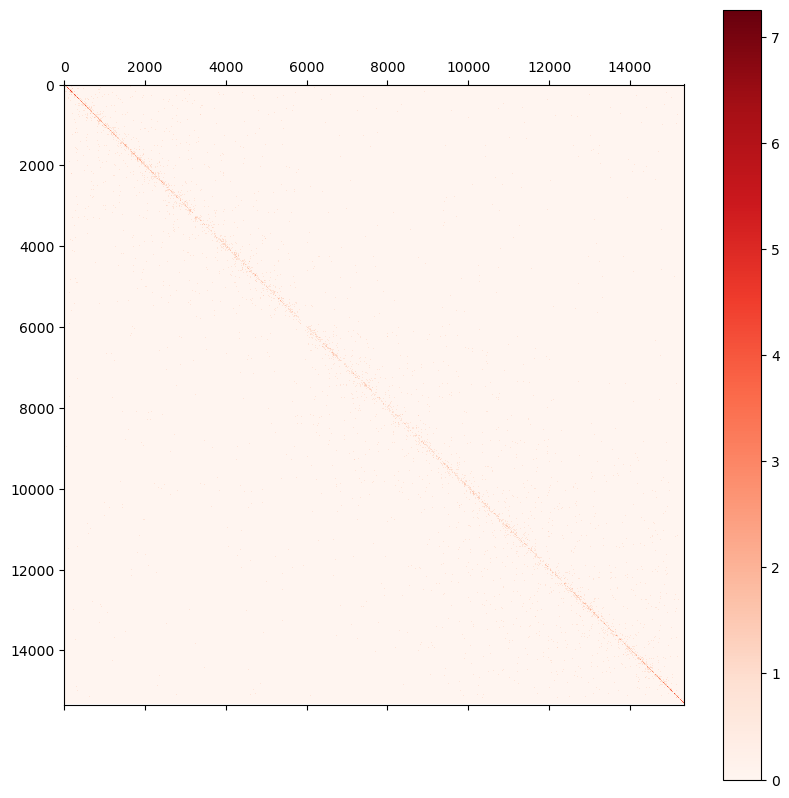

In [8]:
# Plot with matplotlib
fig = plt.figure(figsize=(10,10))
ax =  fig.add_subplot(111)
im =  ax.matshow(np.log1p(arr), cmap="Reds")
fig.colorbar(im)

## Merge the replicates according to SRA ID

### First, subset the chromosomes to only the real chromosomes

In [70]:
print(filepath)
print(filepath.replace('nodups', 'subset.nodups'))

../steps/bwa/PE/pairs/cool/SRR6502335.nodups.10000.cool
../steps/bwa/PE/pairs/cool/SRR6502335.subset.nodups.10000.cool


#### Make a loop

In [47]:
import cooler
import os.path as op
from pprintpp import pprint as pp

coolers = [f"../steps/bwa/PE/pairs/cool/SRR650233{n}.nodups.10000.cool" for n in range(5,10)]
print(f"Subsetting coolers and merging replicates from")
pp(coolers)

for cool in coolers:
    # Filenames
    cool_file = cool
    output_cool_file = cool_file.replace('nodups', 'subset.nodups')

    if op.exists(output_cool_file):
        print(f"Skipping {cool_file} (exists)")
        continue

    print(f"Input: {cool_file} \nOutput: {output_cool_file}\n\nInitializing cooler from input...")
    
    # Load the original .cool file
    c = cooler.Cooler(cool_file)
    
    # Define the chromosomes to keep (e.g., excluding unplaced scaffolds/contigs)
    chroms_to_keep = c.chroms()[0:22]['name']
    
    # Filter the bins to include only the selected chromosomes
    print("Filtering bins...")
    
    bins = c.bins()[:]
    filtered_bins = bins[bins['chrom'].isin(chroms_to_keep)]
    
    # Filter the pixels to include only the selected bins
    print("Filtering pixels...")
    
    bin_ids_to_keep = set(filtered_bins.index)
    pixels = c.pixels()[:]
    filtered_pixels = pixels[pixels['bin1_id'].isin(bin_ids_to_keep) & pixels['bin2_id'].isin(bin_ids_to_keep)]

    # Subset the coolers

    print("Creating subsetted cooler...")

    cooler.create_cooler(
        cool_uri=output_cool_file,
        bins=filtered_bins,
        pixels=filtered_pixels,
        assembly='rheMac10',  # Optional: specify the genome assembly
        ordered=True,  # Assuming the input chunks are in the correct order
        symmetric_upper=True,  # Assuming the input data references the upper triangle of a symmetric matrix
        mode='w',  # Write mode
        ensure_sorted=True,  # Ensure that each input chunk is properly sorted
        boundscheck=True,  # Check that all bin IDs lie in the expected range
        dupcheck=True,  # Check that no duplicate pixels exist within any chunk
        triucheck=True  # Check that bin1_id <= bin2_id when creating coolers in symmetric-upper mode
    )

    print(f"Subset .cool file created: {output_cool_file}")


Subsetting coolers and merging replicates from
[
    '../steps/bwa/PE/pairs/cool/SRR6502335.nodups.10000.cool',
    '../steps/bwa/PE/pairs/cool/SRR6502336.nodups.10000.cool',
    '../steps/bwa/PE/pairs/cool/SRR6502337.nodups.10000.cool',
    '../steps/bwa/PE/pairs/cool/SRR6502338.nodups.10000.cool',
    '../steps/bwa/PE/pairs/cool/SRR6502339.nodups.10000.cool',
]
Skipping ../steps/bwa/PE/pairs/cool/SRR6502335.nodups.10000.cool (exists)
Skipping ../steps/bwa/PE/pairs/cool/SRR6502336.nodups.10000.cool (exists)
Skipping ../steps/bwa/PE/pairs/cool/SRR6502337.nodups.10000.cool (exists)
Skipping ../steps/bwa/PE/pairs/cool/SRR6502338.nodups.10000.cool (exists)
Skipping ../steps/bwa/PE/pairs/cool/SRR6502339.nodups.10000.cool (exists)


In [48]:
# Merge rep1
rep1_out = "../steps/bwa/PE/pairs/cool/fib_rep1.10000.cool"
if not op.exists(rep1_out):
    cooler.merge_coolers(output_uri = rep1_out,
                         input_uris = ["../steps/bwa/PE/pairs/cool/SRR6502335.subset.nodups.10000.cool",
                                      "../steps/bwa/PE/pairs/cool/SRR6502336.subset.nodups.10000.cool"],
                         mergebuf = 20000000)
else:
    print(f"{rep1_out} already exists")

../steps/bwa/PE/pairs/cool/fib_rep1.10000.cool already exists


In [49]:
# Merge rep2
rep2_out = "../steps/bwa/PE/pairs/cool/fib_rep2.10000.cool"
if not op.exists(rep2_out):
    cooler.merge_coolers(output_uri = rep2_out,
                         input_uris = ["../steps/bwa/PE/pairs/cool/SRR6502337.subset.nodups.10000.cool",
                                      "../steps/bwa/PE/pairs/cool/SRR6502338.subset.nodups.10000.cool",
                                      "../steps/bwa/PE/pairs/cool/SRR6502339.subset.nodups.10000.cool"],
                         mergebuf = 20000000)
else:
    print(f"{rep1_out} already exists")

../steps/bwa/PE/pairs/cool/fib_rep1.10000.cool already exists


In [55]:
c_rep1 = cooler.Cooler("../steps/bwa/PE/pairs/cool/fib_rep1.10000.cool")
c_rep2 = cooler.Cooler("../steps/bwa/PE/pairs/cool/fib_rep2.10000.cool")

pp(c_rep1.info) 
pp(c_rep2.info)

{
    'bin-size': 10000,
    'bin-type': 'fixed',
    'creation-date': '2024-10-08T21:02:38.036175',
    'format': 'HDF5::Cooler',
    'format-url': 'https://github.com/open2c/cooler',
    'format-version': 3,
    'generated-by': 'cooler-0.10.2',
    'genome-assembly': 'rheMac10',
    'metadata': {},
    'nbins': 285406,
    'nchroms': 22,
    'nnz': 112572916,
    'storage-mode': 'symmetric-upper',
    'sum': 211718459,
}
{
    'bin-size': 10000,
    'bin-type': 'fixed',
    'creation-date': '2024-10-08T21:52:32.813516',
    'format': 'HDF5::Cooler',
    'format-url': 'https://github.com/open2c/cooler',
    'format-version': 3,
    'generated-by': 'cooler-0.10.2',
    'genome-assembly': 'rheMac10',
    'metadata': {},
    'nbins': 285406,
    'nchroms': 22,
    'nnz': 117207943,
    'storage-mode': 'symmetric-upper',
    'sum': 211294810,
}


## `zoomify` the merged replicates

Generate an `.mcool` file containing coarser resolution to be called.

In [10]:
import cooler
import os.path as op

cool_paths = {'rep1': "../steps/bwa/PE/pairs/cool/fib_rep1.10000.cool",
              'rep2': "../steps/bwa/PE/pairs/cool/fib_rep2.10000.cool"}

mcool_paths = {'rep1': "../steps/bwa/PE/pairs/cool/fib_rep1.mcool",
               'rep2': "../steps/bwa/PE/pairs/cool/fib_rep2.mcool"}

for cool,path in cool_paths.items():
    if op.exists(mcool_paths[cool]):
        print(f"Skipping: {mcool_paths[cool]} already exists")
        continue

    print(f"Zoomifying cooler: \n\t   {path}\n\t-> {mcool_paths[cool]}", end="\n")
    
    cooler.zoomify_cooler(base_uris = path,
                          outfile = mcool_paths[cool],
                          resolutions = [10000,50000,100000,500000],
                          chunksize = 10000000,
                          nproc = 4)
    print(" --> done")

Skipping: ../steps/bwa/PE/pairs/cool/fib_rep1.mcool already exists
Skipping: ../steps/bwa/PE/pairs/cool/fib_rep2.mcool already exists


In [11]:
# to print which resolutions are stored in the mcool, use list_coolers
cooler.fileops.list_coolers(mcool_paths['rep1'])

['/resolutions/10000',
 '/resolutions/50000',
 '/resolutions/100000',
 '/resolutions/500000']

In [12]:
c1 = cooler.Cooler("../steps/bwa/PE/pairs/cool/fib_rep1.mcool::resolutions/100000")
c2 = cooler.Cooler("../steps/bwa/PE/pairs/cool/fib_rep2.mcool::resolutions/100000")

In [13]:
c1.info

{'bin-size': 100000,
 'bin-type': 'fixed',
 'creation-date': '2024-10-08T22:48:20.327186',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/open2c/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.10.2',
 'genome-assembly': 'unknown',
 'metadata': {},
 'nbins': 28550,
 'nchroms': 22,
 'nnz': 52382089,
 'storage-mode': 'symmetric-upper',
 'sum': 211718459}

In [14]:
arr1 = c1.matrix(balance=False).fetch('chrX')
arr2 = c2.matrix(balance=False).fetch('chrX')

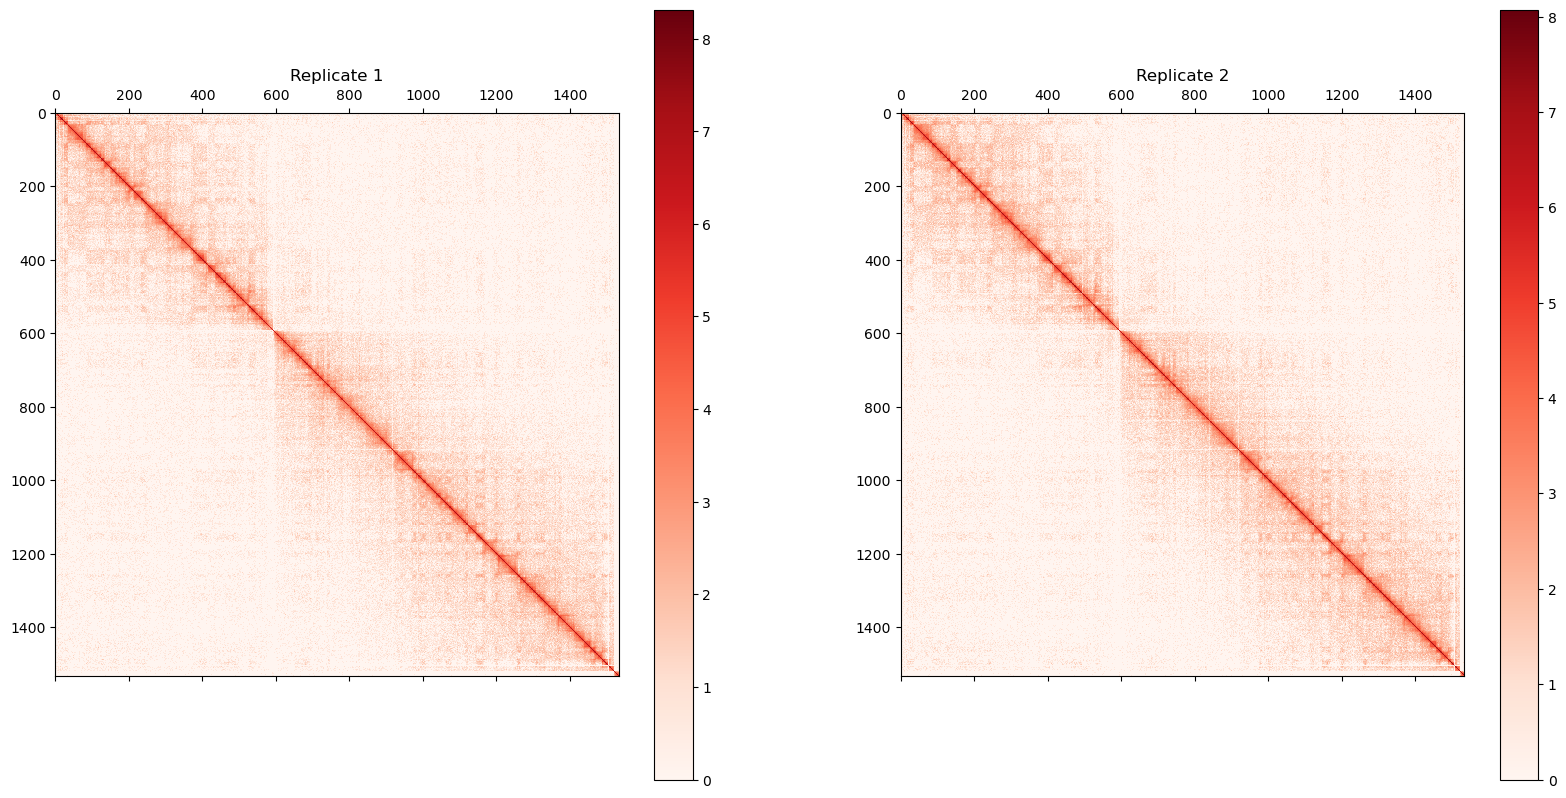

In [91]:
#| label: cooler-map-uncorrected-100kb
#| fig-cap: "The X chromosome in 100kb bins and the first 3 PCs below. UNCORRECTED. Made with `cooler` and `matplotlib`."




# Plot with matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first replicate
im1 = ax1.matshow(np.log1p(arr1), cmap="Reds")
ax1.set_title('Replicate 1')
fig.colorbar(im1, ax=ax1)

# Plot the second replicate
im2 = ax2.matshow(np.log1p(arr2), cmap="Reds")
ax2.set_title('Replicate 2')
fig.colorbar(im2, ax=ax2)

plt.show()

### Follow `cooltools´ suggestion/guide

In [2]:
import cooler

c1 = cooler.Cooler("../steps/bwa/PE/pairs/cool/fib_rep1.mcool::resolutions/500000")
clr = cooler.Cooler("../steps/bwa/PE/pairs/cool/fib_rep1.mcool::resolutions/100000")
c2 = cooler.Cooler("../steps/bwa/PE/pairs/cool/fib_rep1.mcool::resolutions/50000")

In [4]:
### to print chromosomes and binsize for this cooler
print(f'chromosomes: {c1.chromnames}, binsize: {c1.binsize}')
print(f'chromosomes: {clr.chromnames}, binsize: {clr.binsize}')
print(f'chromosomes: {c2.chromnames}, binsize: {c2.binsize}')

### to make a list of chromosome start/ends in bins:
chromstarts = []
chromstarts500kb = []
chromstarts50kb = []
for i in clr.chromnames:
    chromstarts500kb.append(c1.extent(i)[0])
    chromstarts.append(clr.extent(i)[0])
    chromstarts50kb.append(c2.extent(i)[0])

chromosomes: ['chr1', 'chr2', 'chr5', 'chr3', 'chr6', 'chr4', 'chr7', 'chrX', 'chr8', 'chr9', 'chr11', 'chr12', 'chr14', 'chr15', 'chr13', 'chr10', 'chr17', 'chr16', 'chr20', 'chr18', 'chr19', 'chrY'], binsize: 500000
chromosomes: ['chr1', 'chr2', 'chr5', 'chr3', 'chr6', 'chr4', 'chr7', 'chrX', 'chr8', 'chr9', 'chr11', 'chr12', 'chr14', 'chr15', 'chr13', 'chr10', 'chr17', 'chr16', 'chr20', 'chr18', 'chr19', 'chrY'], binsize: 100000
chromosomes: ['chr1', 'chr2', 'chr5', 'chr3', 'chr6', 'chr4', 'chr7', 'chrX', 'chr8', 'chr9', 'chr11', 'chr12', 'chr14', 'chr15', 'chr13', 'chr10', 'chr17', 'chr16', 'chr20', 'chr18', 'chr19', 'chrY'], binsize: 50000


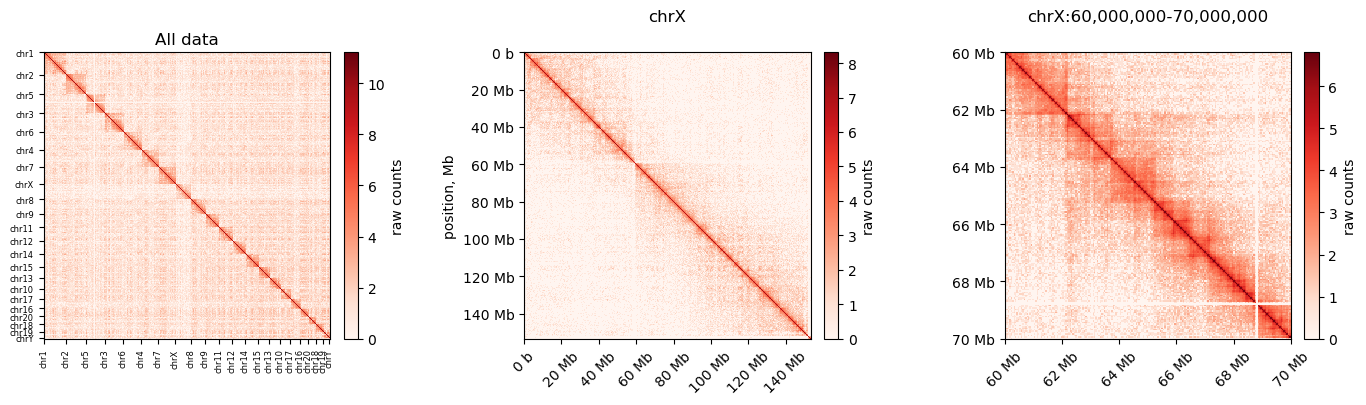

In [6]:
#| label: rep1-ncol3-cooltools-uncorrected
#| fig-cap: "Left: All chromosomes plotted in 100kb bins. Middle: chrX in 100kb bins. Right: chrX:60Mb-70Mb in 50 kb bins"

# to plot ticks in terms of megabases we use the EngFormatter
# https://matplotlib.org/gallery/api/engineering_formatter.html
# Also, here we fetch the chromosomes directly from within the plot
# Import the packages we will use
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py

# The following directive activates inline plotting
%matplotlib inline

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)


f, axs = plt.subplots(
    figsize=(14,4),
    ncols=3)

ax = axs[0]
im = ax.matshow(np.log1p(c1.matrix(balance=False)[:]), 
                #vmax=2500, 
                cmap='Reds');
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_xticks(chromstarts500kb)
ax.set_xticklabels(c1.chromnames, fontsize=6)
ax.set_yticks(chromstarts500kb)
ax.set_yticklabels(c1.chromnames, fontsize=6)
ax.xaxis.tick_bottom()
ax.tick_params(axis='x',rotation=90)
ax.set_title('All data')

ax = axs[1]
im = ax.matshow(
    np.log1p(clr.matrix(balance=False).fetch('chrX')),
    cmap='Reds',
    #vmax=2500,
    extent=(0,clr.chromsizes['chrX'], clr.chromsizes['chrX'], 0)
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_title('chrX', y=1.08)
ax.set_ylabel('position, Mb')
format_ticks(ax)

ax = axs[2]
start, end = 60_000_000, 70_000_000
region = ('chrX', start, end)
im = ax.matshow(
    np.log1p(c2.matrix(balance=False).fetch(region)),
    #vmax=2500,
    cmap='Reds',
    extent=(start, end, end, start)
);
ax.set_title(f'chrX:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
format_ticks(ax)
plt.tight_layout()

## Balance the matrices (iterative correction)

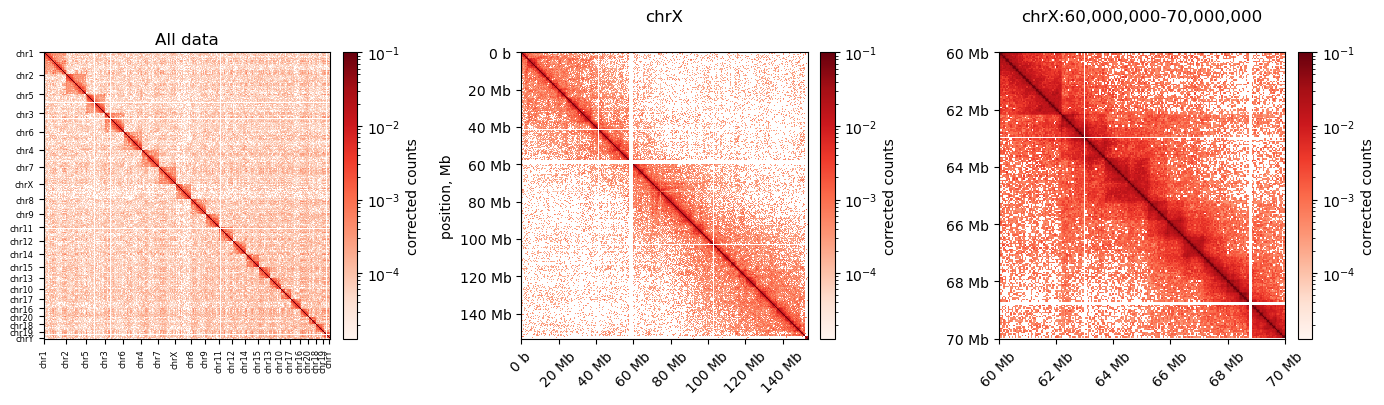

In [5]:
#| label: rep1-ncol3-cooltools-corrected
#| fig-cap: "Left: All chromosomes plotted in 100kb bins. Middle: chrX in 100kb bins. Right: chrX:60Mb-70Mb in 50 kb bins"

# to plot ticks in terms of megabases we use the EngFormatter
# https://matplotlib.org/gallery/api/engineering_formatter.html
# Also, here we fetch the chromosomes directly from within the plot
# Import the packages we will use
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py

# The following directive activates inline plotting
%matplotlib inline

from matplotlib.ticker import EngFormatter
from matplotlib.colors import LogNorm

bp_formatter = EngFormatter('b')
norm = LogNorm(vmax=0.1)

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)


f, axs = plt.subplots(
    figsize=(14,4),
    ncols=3)

ax = axs[0]
im = ax.matshow(c1.matrix(balance=True)[:], 
                #vmax=2500, 
                norm=norm,
                cmap='Reds');
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='corrected counts');
ax.set_xticks(chromstarts500kb)
ax.set_xticklabels(c1.chromnames, fontsize=6)
ax.set_yticks(chromstarts500kb)
ax.set_yticklabels(c1.chromnames, fontsize=6)
ax.xaxis.tick_bottom()
ax.tick_params(axis='x',rotation=90)
ax.set_title('All data')

ax = axs[1]
im = ax.matshow(
    clr.matrix(balance=True).fetch('chrX'),
    cmap='Reds',
    norm=norm,
    extent=(0,clr.chromsizes['chrX'], clr.chromsizes['chrX'], 0)
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='corrected counts');
ax.set_title('chrX', y=1.08)
ax.set_ylabel('position, Mb')
format_ticks(ax)

ax = axs[2]
start, end = 60_000_000, 70_000_000
region = ('chrX', start, end)
im = ax.matshow(
    c2.matrix(balance=True).fetch(region),
    #vmax=2500,
    norm=norm,
    cmap='Reds',
    extent=(start, end, end, start)
);
ax.set_title(f'chrX:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='corrected counts');
format_ticks(ax)
plt.tight_layout()

In [16]:
c1.matrix(balance=False).fetch('chrX')

array([[2214,  944,  362, ...,    1,    1,    0],
       [ 944, 6699, 1066, ...,    6,    2,    2],
       [ 362, 1066, 7639, ...,    2,    1,    2],
       ...,
       [   1,    6,    2, ..., 4317,  771,  292],
       [   1,    2,    1, ...,  771, 7897, 1001],
       [   0,    2,    2, ...,  292, 1001, 5077]], dtype=int32)

In [6]:
c1.bins()[:10]

,chrom,start,end,weight
0,chr1,0,500000,0.006092
1,chr1,500000,1000000,0.008288
2,chr1,1000000,1500000,0.006928
3,chr1,1500000,2000000,0.005282
4,chr1,2000000,2500000,0.005112
5,chr1,2500000,3000000,0.005096
6,chr1,3000000,3500000,0.005121
7,chr1,3500000,4000000,0.004835
8,chr1,4000000,4500000,0.004252
9,chr1,4500000,5000000,0.004451
